In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # отключаем предупреждения Anaconda

In [2]:
# считываем данные из файла 'crx.data.txt' с разделителем ',' и обозначением пропущенных значений '?'
crx_data = pd.read_csv('crx.data.txt', sep=',', header=None, na_values='?')

# назовем признаки так, как это указано в описании данных
crx_data.columns = ['A'+str(i+1) for i in range(crx_data.shape[1])]
crx_data.head(10)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.500,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,f,s,120.0,0,+
5,b,32.08,4.000,u,g,m,v,2.500,t,f,0,t,g,360.0,0,+
6,b,33.17,1.040,u,g,r,h,6.500,t,f,0,t,g,164.0,31285,+
7,a,22.92,11.585,u,g,cc,v,0.040,t,f,0,f,g,80.0,1349,+
8,b,54.42,0.500,y,p,k,h,3.960,t,f,0,f,g,180.0,314,+
9,b,42.50,4.915,y,p,w,v,3.165,t,f,0,t,g,52.0,1442,+


In [3]:
# чтобы в дальнейшем не возникло проблем, преобразуем целочисленные переменные в действительные
# (в описании данных указано, что A11 и A15 непрерывные, т.е. не категориальные, поэтому можем так сделать)
crx_data[['A11', 'A15']] = crx_data[['A11', 'A15']].astype(float)
crx_data.dropna(inplace=True)

X = crx_data.iloc[:, :-1]

y = crx_data.iloc[:, -1] # выделим целевую переменную (класс)


# Преобразуем категориальные признаки (OneHotEnconding)
# Каждому признаку с k уникальными значениями ставится в соответствие k-1 бинарный признак
X = pd.get_dummies(X, prefix=[column for column in X.columns if X[column].dtype == object], 
                   drop_first=True)

# Разделим на обучающую (70%) и тестовую выборки (30%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=10)

# стандартизируем данные, чтобы по значению коэффициента переменной можно было судить о величине ее вклада в классификацию
from sklearn.preprocessing import StandardScaler # вычитает среднее и делит на стандартное отклонение

scaler_train = StandardScaler().fit(X_train) # оценим параметры стандартизации по обучающей выборке
X_train = scaler_train.transform(X_train) # стандартизируем обучающую выборку
X_test = scaler_train.transform(X_test) # стандартизируем тестовую выборку

Чтобы оценить преимущество ансамблевых классификаторов, возьмем в качестве baseline логистическую регрессию с параметрами, подобранными по кросс-валидации (смотри тетрадку по классификации), так как среди сравниваемых не ансамблевых классификаторов она показала наилучшие результаты.

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score

log_l2_clf = SGDClassifier(loss='log', penalty='l2', alpha=0.035, max_iter=10*5, 
                        n_jobs=4, random_state=0, learning_rate='optimal')

log_l2_clf.fit(X_train, y_train)

print('Свободный параметр: {}'.format(log_l2_clf.intercept_[0]))
print('Параметры: ')
print(log_l2_clf.coef_)
print('\nЧисло итераций: {}\n'.format(log_l2_clf.n_iter_))
print('Accuracy на обучающей выборке: {:.4f}'.format(accuracy_score(y_train, log_l2_clf.predict(X_train))))
print('Accuracy на тестовой выбоорке: {:.4f}'.format(accuracy_score(y_test, log_l2_clf.predict(X_test))))

Свободный параметр: 0.395581705726
Параметры: 
[[ -6.80209789e-02  -8.33302620e-02  -2.05838733e-01  -5.23075987e-01
    1.54743590e-01  -4.05977241e-01  -5.84346291e-02  -6.02866395e-02
    8.36491291e-02  -2.12043383e-01   8.36491291e-02  -4.03366066e-04
   -9.30585688e-02  -4.34794729e-02  -1.95961402e-01   2.27212074e-01
    1.80610278e-01   1.25492680e-01   1.55560166e-01   6.84127146e-03
   -4.90835410e-02  -4.05124755e-02  -2.15960013e-01  -2.06507643e-01
    3.76350785e-02   1.39310176e-01  -1.93717324e-01  -1.77599722e-01
    4.12157959e-02   3.26498741e-02  -1.07976271e-01   2.73592974e-02
   -1.26559175e+00  -2.98663749e-01   8.18393479e-02   0.00000000e+00
    4.31966019e-02]]

Число итераций: 50

Accuracy на обучающей выборке: 0.8972
Accuracy на тестовой выбоорке: 0.8469


## Bagging

Различные варианты Bagging'а и соответствующие им значения параметров [BaggingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) и [BaggingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor) в sklearn.

* Pasting: случайные выборки объектов из имеющегося набора данных (0 < max_samples < 1.0, max_features=1.0, bootstrap=False)
* Bagging: случаные выборки объектов с повторениями из имеющегося набора данных (0 < max_samples <= 1.0, max_features=1.0, bootstrap=True)
* Random Subspaces: случайные выборки признаков (max_samples=1.0, 0 < max_features < 1.0, bootstrap=False)
* Random Patches: случайные выборки объектов и признаков (0 < max_samples < 1.0, 0 < max_features < 1.0, boostrap=False или True)

#### !!! Внимание, следующий блок кода может должго выполняться. В классе его рекомендуется запустить с меньшими значениями max_iter и n_estimators.

In [5]:
from sklearn.ensemble import BaggingClassifier

# В качестве базового классификатора возьмем логистическую регрессию без регуляризации.
# Берем без регуляризации, так как для bagging'a необходимы переобученные базовые модели,
# т.е. модели высокой сложности.
# Можно проверить, что с регуляризацией качество классификации ухудшится.
base_classifier = SGDClassifier(loss='log', penalty='none', max_iter=10**5)

# Pasting: обучаемся на 70% случайно выбранных объектах, повторяем 21 раз
pasting = BaggingClassifier(base_classifier, max_samples=.7, max_features=1., bootstrap=False, 
                            n_estimators=21, n_jobs=4, random_state=0)

# Bagging: обучаемся на 70% случаной выбранных объектах с возвращением, повторяем 21 раз
bagging = BaggingClassifier(base_classifier, max_samples=.7, max_features=1., bootstrap=True, 
                            n_estimators=21, n_jobs=4, random_state=0)

# Random Subspaces: обучаемся на 50% случано выбранных признаках, повторяем 21 раз
random_subspaces = BaggingClassifier(base_classifier, max_samples=1., max_features=.5, bootstrap=False, 
                                     n_estimators=21, n_jobs=4, random_state=0)

# Randomm Patches: обучаемся на 70% случайно выбранных объектов с возвращением и 70% случайно выбранных признаков,
# повторяем 21 раз
random_patches = BaggingClassifier(base_classifier, max_samples=.7, max_features=.7, bootstrap=True, 
                                   n_estimators=21, n_jobs=4, random_state=0)

pasting.fit(X_train, y_train)
bagging.fit(X_train, y_train)
random_subspaces.fit(X_train, y_train)
random_patches.fit(X_train, y_train)

print('Pasting')
print('Accuracy на обучающей выборке: {:.4f}'.format(accuracy_score(y_train, pasting.predict(X_train))))
print('Accuracy на тестовой выбоорке: {:.4f}'.format(accuracy_score(y_test, pasting.predict(X_test))))

print('\nBagging')
print('Accuracy на обучающей выборке: {:.4f}'.format(accuracy_score(y_train, bagging.predict(X_train))))
print('Accuracy на тестовой выбоорке: {:.4f}'.format(accuracy_score(y_test, bagging.predict(X_test))))

print('\nRandom Subspaces')
print('Accuracy на обучающей выборке: {:.4f}'.format(accuracy_score(y_train, random_subspaces.predict(X_train))))
print('Accuracy на тестовой выбоорке: {:.4f}'.format(accuracy_score(y_test, random_subspaces.predict(X_test))))

print('\nRandom Patches')
print('Accuracy на обучающей выборке: {:.4f}'.format(accuracy_score(y_train, random_patches.predict(X_train))))
print('Accuracy на тестовой выбоорке: {:.4f}'.format(accuracy_score(y_test, random_patches.predict(X_test))))

Pasting
Accuracy на обучающей выборке: 0.8950
Accuracy на тестовой выбоорке: 0.8367

Bagging
Accuracy на обучающей выборке: 0.9059
Accuracy на тестовой выбоорке: 0.8418

Random Subspaces
Accuracy на обучающей выборке: 0.8906
Accuracy на тестовой выбоорке: 0.8367

Random Patches
Accuracy на обучающей выборке: 0.8862
Accuracy на тестовой выбоорке: 0.8214


Из четырех вариантов лучшим оказался bagging, его и будем использовать в сравнении с другими ансамблями. При этом он превзошел по качеству логистическую регрессию на тестовой выборке. Разница в ошибке между обучающей и тестовой выборками также меньше, чем для логистической регресси, что, вообще говоря, тоже хороший знак.

Можно посомотреть, какие модели обучались в ансамбле. Например, первая модель в bagging.

In [6]:
bagging.estimators_[0]

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=100000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=2087557356,
       shuffle=True, tol=None, verbose=0, warm_start=False)

Так можно увидеть номера объектов, которые попали в первую подвыборку.

In [7]:
np.arange(X_train.shape[0])[bagging.estimators_samples_[0]]

array([  0,   1,   3,   4,   5,   9,  12,  16,  22,  24,  25,  26,  31,
        32,  36,  38,  41,  44,  45,  49,  53,  55,  56,  57,  59,  60,
        62,  64,  65,  66,  71,  73,  75,  76,  79,  80,  81,  84,  87,
        88,  90,  91,  92,  93,  97,  98, 100, 101, 102, 103, 108, 109,
       111, 114, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 128,
       129, 133, 134, 135, 136, 137, 138, 139, 140, 143, 144, 146, 148,
       150, 154, 156, 158, 159, 164, 165, 167, 169, 170, 171, 173, 174,
       175, 176, 177, 183, 184, 186, 190, 192, 193, 194, 195, 197, 198,
       201, 203, 206, 207, 213, 214, 215, 216, 218, 219, 220, 221, 224,
       227, 229, 230, 232, 234, 235, 236, 237, 239, 240, 242, 245, 249,
       251, 257, 259, 263, 265, 266, 269, 270, 272, 273, 276, 278, 279,
       281, 282, 284, 286, 288, 289, 295, 301, 303, 304, 305, 310, 312,
       315, 317, 323, 324, 325, 326, 330, 333, 335, 342, 345, 346, 347,
       349, 351, 353, 358, 360, 361, 362, 365, 366, 367, 368, 37

А так увидеть номера признаков, которые использовались для обучения первой модели в ансамбле.

In [8]:
np.arange(X_test.shape[0])[bagging.estimators_features_[0]]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36], dtype=int64)

Также для большинства классификаторов и ансамблевых методов доступна опция warm_start=True, которая при наличии новой порции данных для обучения "дообучает" модель. Ниже исключительно в целях демонтсрации приведен пример, как это сделать в случае с Bagging'ом. Для других моделей аналогично. Это полезно делать, если данные большие или поступают постепенно и нет возможности хранить их целиком.

In [9]:
# обратите внимание на параметр warm_start=True, иначе не на новой порции данных модель будет обучаться с 0.
bagging_warm = BaggingClassifier(base_classifier, max_samples=.7, max_features=1., bootstrap=True, 
                                 n_estimators=11, n_jobs=4, random_state=0, warm_start=True)

X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=.5)

# Предположим, что сначала нам была доступна только половина данных для обучения (X_train1, y_train1) и мы обучаем модель
bagging_warm.fit(X_train1, y_train1)
# После получения второй части данных для обучения, мы уточняем уже обученную модель
bagging_warm.fit(X_train2, y_train2)

print('Accuracy на обучающей выборке: {:.4f}'.format(accuracy_score(y_train, bagging_warm.predict(X_train))))
print('Accuracy на тестовой выбоорке: {:.4f}'.format(accuracy_score(y_test, bagging_warm.predict(X_test))))

Accuracy на обучающей выборке: 0.8862
Accuracy на тестовой выбоорке: 0.8163


## Случайный лес

В scikit-learn есть две реализации случайного леса. Разница заключается в том, как выбираются пороговые значения признаков.

[RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) на каждом шаге просматривает все пороговые значения каждого признака из случайно выбранного подмножества признаков и выбирает признак и порог для него, которые обеспечивают наилучшее на данном шаге разбиение. 

[ExtraTreesClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) для каждого признака из случайного подмножества признаков выбирает случайный порог, а затем выбирает признак, случайны порог которого обеспечил лучшее разбиение на текущем шаге.

Также для обоих подходов существуют реализации для задачи регрессии: [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) и [ExtraTreesRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor).

In [10]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [11]:
random_forest = RandomForestClassifier(n_estimators=1000, criterion='gini', max_features='sqrt', 
                                       n_jobs=4, random_state=0, bootstrap=True, max_depth=10, 
                                       min_samples_split=30)
random_forest.fit(X_train, y_train)

print('Accuracy на обучающей выборке: {:.4f}'.format(accuracy_score(y_train, random_forest.predict(X_train))))
print('Accuracy на тестовой выбоорке: {:.4f}'.format(accuracy_score(y_test, random_forest.predict(X_test))))

# Случайные леса, в том числе, осуществляют оценку важности признаков
print('\nВажность признаков: ')
for i, c in enumerate(X.columns[:-1]):
    print(c + ': ' + '%.4f' % random_forest.feature_importances_[i])

Accuracy на обучающей выборке: 0.9300
Accuracy на тестовой выбоорке: 0.8673

Важность признаков: 
A2: 0.0275
A3: 0.0375
A8: 0.0951
A11: 0.1427
A14: 0.0334
A15: 0.0864
A1_b: 0.0022
A4_u: 0.0051
A4_y: 0.0051
A5_gg: 0.0026
A5_p: 0.0057
A6_c: 0.0023
A6_cc: 0.0020
A6_d: 0.0015
A6_e: 0.0020
A6_ff: 0.0100
A6_i: 0.0053
A6_j: 0.0006
A6_k: 0.0064
A6_m: 0.0013
A6_q: 0.0049
A6_r: 0.0000
A6_w: 0.0081
A6_x: 0.0075
A7_dd: 0.0007
A7_ff: 0.0084
A7_h: 0.0128
A7_j: 0.0028
A7_n: 0.0002
A7_o: 0.0000
A7_v: 0.0021
A7_z: 0.0007
A9_t: 0.3823
A10_t: 0.0869
A12_t: 0.0036
A13_p: 0.0000


RandomForest c выбранными параметрами оказался лучше, чем Bagging. Самым важным признаком RandomForest считает признак A9==t, второй по важности A11. Оценку важности признаков, полученную при помощи случайного леса можно использовать в качестве весов для других классификаторов или для отбора признаков.

Также можно посомтреть, какие модели обучались в ансамбле.

In [12]:
random_forest.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=30,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=209652396, splitter='best')

Все то же самое для ExtraTreesClassifier.

In [13]:
extra_trees = ExtraTreesClassifier(n_estimators=1000, criterion='gini', max_features='sqrt', 
                                   n_jobs=4, random_state=0, class_weight='balanced', bootstrap=True)

extra_trees.fit(X_train, y_train)

print('Accuracy на обучающей выборке: {:.4f}'.format(accuracy_score(y_train, extra_trees.predict(X_train))))
print('Accuracy на тестовой выбоорке: {:.4f}'.format(accuracy_score(y_test, extra_trees.predict(X_test))))
print('\nВажность признаков: ')
for i, c in enumerate(X.columns[:-1]):
    print(c + ': ' + '%.4f' % extra_trees.feature_importances_[i])

Accuracy на обучающей выборке: 1.0000
Accuracy на тестовой выбоорке: 0.8724

Важность признаков: 
A2: 0.0443
A3: 0.0446
A8: 0.0550
A11: 0.0497
A14: 0.0435
A15: 0.0354
A1_b: 0.0161
A4_u: 0.0095
A4_y: 0.0109
A5_gg: 0.0024
A5_p: 0.0099
A6_c: 0.0162
A6_cc: 0.0049
A6_d: 0.0056
A6_e: 0.0047
A6_ff: 0.0151
A6_i: 0.0140
A6_j: 0.0018
A6_k: 0.0174
A6_m: 0.0076
A6_q: 0.0114
A6_r: 0.0001
A6_w: 0.0159
A6_x: 0.0106
A7_dd: 0.0013
A7_ff: 0.0120
A7_h: 0.0199
A7_j: 0.0057
A7_n: 0.0004
A7_o: 0.0001
A7_v: 0.0138
A7_z: 0.0010
A9_t: 0.3689
A10_t: 0.0928
A12_t: 0.0245
A13_p: 0.0000


ExtraTreesCalssifier с выбранными параметрами по доле верных предсказаний превосходит все другие обученные ранее классификаторы.

http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py Здесь можно посмотреть, как построить графики того, как изменяется ошибка предсказания с ростом числа деревьев в случайном лече.

## Бустинг

Бустинг в scikit-learn представлен двумя подходами [AdaBoostClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) и [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier). Есть также версии для задачи регрессии: [AdaBoostRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor) и [GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor).

Важно помнить, что в отличие от Bagging'а в качестве базового классификатора для AdaBoost необходимо брать модели низкой сложности. Например, деревья глубины 1.

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), 
                               n_estimators=1000, learning_rate=.1, 
                               algorithm='SAMME', random_state=0)

ada_boost.fit(X_train, y_train)

print('Accuracy на обучающей выборке: {:.4f}'.format(accuracy_score(y_train, ada_boost.predict(X_train))))
print('Accuracy на тестовой выбоорке: {:.4f}'.format(accuracy_score(y_test, ada_boost.predict(X_test))))
print('\nВажность признаков: ')
for i, c in enumerate(X.columns[:-1]):
    print(c + ': ' + '%.4f' % ada_boost.feature_importances_[i])

Accuracy на обучающей выборке: 0.8972
Accuracy на тестовой выбоорке: 0.8520

Важность признаков: 
A2: 0.0000
A3: 0.0836
A8: 0.0558
A11: 0.1290
A14: 0.0597
A15: 0.2100
A1_b: 0.0000
A4_u: 0.0000
A4_y: 0.0116
A5_gg: 0.0793
A5_p: 0.0061
A6_c: 0.0000
A6_cc: 0.0000
A6_d: 0.0000
A6_e: 0.0315
A6_ff: 0.0574
A6_i: 0.0161
A6_j: 0.0000
A6_k: 0.0087
A6_m: 0.0000
A6_q: 0.0000
A6_r: 0.0000
A6_w: 0.0597
A6_x: 0.0106
A7_dd: 0.0000
A7_ff: 0.0000
A7_h: 0.0000
A7_j: 0.0000
A7_n: 0.0000
A7_o: 0.0000
A7_v: 0.0000
A7_z: 0.0000
A9_t: 0.1808
A10_t: 0.0000
A12_t: 0.0000
A13_p: 0.0000


Доля верных предсказаний выше, чем у логистической регрессии, но ниже чем у ExtraTreesClassifier.

В отличие от случайных лесов самым важным признаком оказался признак A15.

Можно посомтреть на веса классификаторов, добавляемых на каждом шаге.

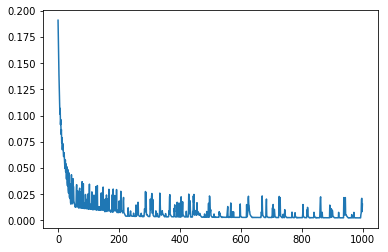

In [15]:
plt.plot(np.arange(len(ada_boost.estimator_weights_)), ada_boost.estimator_weights_)
plt.show()

А так же на ошибку классификации каждого нового классификатора.

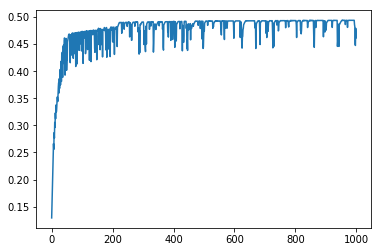

In [16]:
plt.plot(np.arange(len(ada_boost.estimator_errors_)), ada_boost.estimator_errors_)
plt.show()

Пробуем обучить градиентный бустинг.

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting = GradientBoostingClassifier(loss='deviance', learning_rate=.01, n_estimators=1000, 
                                               max_depth=1, subsample=.6, max_features=None, random_state=0)

gradient_boosting.fit(X_train, y_train)

print('Accuracy на обучающей выборке: {:.4f}'.format(accuracy_score(y_train, gradient_boosting.predict(X_train))))
print('Accuracy на тестовой выбоорке: {:.4f}'.format(accuracy_score(y_test, gradient_boosting.predict(X_test))))
print('\nВажность признаков: ')
for i, c in enumerate(X.columns[:-1]):
    print(c + ': ' + '%.4f' % gradient_boosting.feature_importances_[i])

Accuracy на обучающей выборке: 0.8950
Accuracy на тестовой выбоорке: 0.8673

Важность признаков: 
A2: 0.0120
A3: 0.0990
A8: 0.0910
A11: 0.0890
A14: 0.1880
A15: 0.0950
A1_b: 0.0000
A4_u: 0.0050
A4_y: 0.0060
A5_gg: 0.0550
A5_p: 0.0170
A6_c: 0.0000
A6_cc: 0.0020
A6_d: 0.0000
A6_e: 0.0150
A6_ff: 0.0140
A6_i: 0.0150
A6_j: 0.0010
A6_k: 0.0150
A6_m: 0.0000
A6_q: 0.0000
A6_r: 0.0000
A6_w: 0.0330
A6_x: 0.0170
A7_dd: 0.0000
A7_ff: 0.0010
A7_h: 0.0130
A7_j: 0.0090
A7_n: 0.0000
A7_o: 0.0000
A7_v: 0.0010
A7_z: 0.0000
A9_t: 0.1860
A10_t: 0.0170
A12_t: 0.0020
A13_p: 0.0000


Качество выше, чем у логистической регрессии, но ниже чем у чемпиона. Признаки A9_t и A14 посчитал самыми важными.

Можно изобразить на графике, на сколько уменьшалась ошибка при добавлении нового классификатора на каждом шаге.

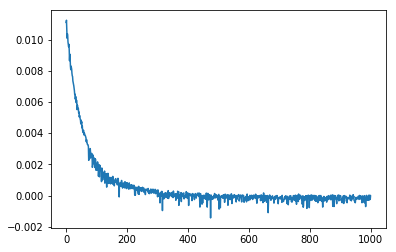

In [18]:
plt.plot(np.arange(len(gradient_boosting.oob_improvement_)), gradient_boosting.oob_improvement_)
plt.show()

А также, как снижалось значение ошибки на обучающей выборке.

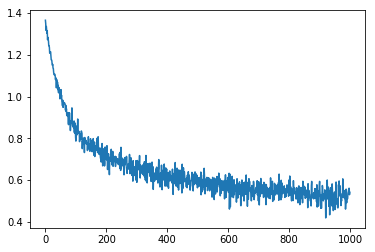

In [19]:
plt.plot(np.arange(len(gradient_boosting.train_score_)), gradient_boosting.train_score_)
plt.show()

## Голосование

Еще один вариант ансамбля, предназнначенный для задачи классификации - голосование.

In [20]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# выберем 5 классификаторов
clf1 = SGDClassifier(loss='log', penalty='l2', alpha=0.035, max_iter=10000, random_state=100, n_jobs=4)
clf2 = KNeighborsClassifier(n_neighbors=48, weights='distance', n_jobs=4)
clf3 = GaussianNB()
clf4 = SVC(C=0.87, kernel='sigmoid', probability=True, random_state=0)
clf5 = DecisionTreeClassifier(criterion='gini', max_depth=7, max_features='sqrt', min_samples_split=23, 
                              splitter='random', random_state=0)

# финальное предсказание будем делать путем голосования с весами классификаторов (weights)
voting = VotingClassifier(estimators=[('log', clf1), ('knn', clf2), ('nb', clf3), ('svm', clf4), ('dt', clf5)],
                          weights=[1, 1, 1, 1, 10], voting='soft', n_jobs=4)

voting.fit(X_train, y_train)

print('Accuracy на обучающей выборке: {:.4f}'.format(accuracy_score(y_train, voting.predict(X_train))))
print('Accuracy на тестовой выбоорке: {:.4f}'.format(accuracy_score(y_test, voting.predict(X_test))))


Accuracy на обучающей выборке: 0.9147
Accuracy на тестовой выбоорке: 0.8571


## Оценка

Если нам необходимо оценить качество классификации не для одного класса, а для всех классов в среднем, для таких мер как precision, recall, f1-мера и auc применяются различный процедуры усреднения (см. памятку по multiclass classification).

Здесь воспользуемся двумя стратегиями усреднения: micro и macro.

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score

predictions = {'Logistic Regression': log_l2_clf.predict(X_test),
               'Bagging': bagging.predict(X_test),
               'AdaBoost': ada_boost.predict(X_test),
               'GradientBoosting': gradient_boosting.predict(X_test),
               'Random Forest': random_forest.predict(X_test),
               'Extra Trees': extra_trees.predict(X_test),
               'Voting': voting.predict(X_test)
              }

In [22]:
print('Precision: ')
for model in predictions:
    print('\t' + model + ': micro %.4f' % precision_score(y_test, predictions[model], average='micro') + 
          ': macro %.4f' % precision_score(y_test, predictions[model], average='macro'))
    
print('Recall: ')
for model in predictions:
    print('\t' + model + ': micro %.4f' % recall_score(y_test, predictions[model], average='micro') + 
          ': macro %.4f' % recall_score(y_test, predictions[model], average='macro'))
    
print('F1-score: ')
for model in predictions:
    print('\t' + model + ': micro %.4f' % f1_score(y_test, predictions[model], average='micro') + 
          ': macro %.4f' % f1_score(y_test, predictions[model], average='macro'))    

Precision: 
	Bagging: micro 0.8418: macro 0.8415
	Extra Trees: micro 0.8724: macro 0.8722
	GradientBoosting: micro 0.8673: macro 0.8688
	AdaBoost: micro 0.8520: macro 0.8523
	Logistic Regression: micro 0.8469: macro 0.8467
	Voting: micro 0.8571: macro 0.8612
	Random Forest: micro 0.8673: macro 0.8671
Recall: 
	Bagging: micro 0.8418: macro 0.8418
	Extra Trees: micro 0.8724: macro 0.8724
	GradientBoosting: micro 0.8673: macro 0.8688
	AdaBoost: micro 0.8520: macro 0.8528
	Logistic Regression: micro 0.8469: macro 0.8471
	Voting: micro 0.8571: macro 0.8594
	Random Forest: micro 0.8673: macro 0.8675
F1-score: 
	Bagging: micro 0.8418: macro 0.8416
	Extra Trees: micro 0.8724: macro 0.8723
	GradientBoosting: micro 0.8673: macro 0.8673
	AdaBoost: micro 0.8520: macro 0.8520
	Logistic Regression: micro 0.8469: macro 0.8468
	Voting: micro 0.8571: macro 0.8571
	Random Forest: micro 0.8673: macro 0.8672


Оценки micro и macro одной и той же меры качества для одного и того же классификатора мало отличаются. Глядя на результаты можно заключить, что несомтря на то, что по доле верных предсказаний ансамблевые методы не сильно превосходили логистическую регрессию, то при усреднении по двум классам значения мер precision, recall и f1-мера для ансамблей значительно превосходят соответствующие значения для логистической регресии.

Для оценки усредненного AUC необходимы предсказания вероятностей для каждого класса.

In [23]:
from sklearn.preprocessing import MultiLabelBinarizer

probabilities = {'Logistic Regression': log_l2_clf.predict_proba(X_test),
                 'Bagging': bagging.predict_proba(X_test),
                 'AdaBoost': ada_boost.predict_proba(X_test),
                 'GradientBoosting': gradient_boosting.predict_proba(X_test),
                 'Random Forest': random_forest.predict_proba(X_test),
                 'Extra Trees': extra_trees.predict_proba(X_test),
                }

# для оценки roc_auc_score, усредненной по всем классам, необходимо целевую переменную представить 
# в виде набора бинарных переменных
# например, y = ['+', '-', '+'] -> [[1, 0], [0, 1], [1, 0]], если первый столбец соответствует метке '+', а второй - метке '-'
# для этого используется MultiLabelBinarizer

# чтобы столбцы с одинаковым номером в матрицах классов и вероятностей соответствовали одной и той же метке класса,
# на вход MultiLabelBinariazer необходимо подать метки классов в необходимом порядке.
# для обученных классификаторов эту информацию можно получить через .classes_
binary_classes = {'Logistic Regression': MultiLabelBinarizer(log_l2_clf.classes_).fit_transform(y_test),
                   'Bagging': MultiLabelBinarizer(bagging.classes_).fit_transform(y_test),
                   'AdaBoost': MultiLabelBinarizer(ada_boost.classes_).fit_transform(y_test),
                   'GradientBoosting': MultiLabelBinarizer(gradient_boosting.classes_).fit_transform(y_test),
                   'Random Forest': MultiLabelBinarizer(random_forest.classes_).fit_transform(y_test),
                   'Extra Trees': MultiLabelBinarizer(extra_trees.classes_).fit_transform(y_test),
                  }

In [24]:
print('AUC: ')
for model in probabilities:
    print('\t' + model + ': micro %.4f' % roc_auc_score(binary_classes[model], probabilities[model], average='micro') + 
          ': macro %.4f' % roc_auc_score(binary_classes[model], probabilities[model], average='macro'))    

AUC: 
	Bagging: micro 0.9057: macro 0.9044
	Extra Trees: micro 0.9139: macro 0.9140
	GradientBoosting: micro 0.9281: macro 0.9295
	AdaBoost: micro 0.9232: macro 0.9258
	Logistic Regression: micro 0.9160: macro 0.9136
	Random Forest: micro 0.9232: macro 0.9218


Среднее знначение AUC для GradientBoosting оказывается максимальным, хотя по остальным мерам лидировал ExtraTreesClassifier. Вероятно, изменив порог вероятности принадлежности классам можно увеличить точность предсказания градиентного бустинга.

В этой тетрадке не представлен выбор оптимальных параметров для ансамблей. Это можно сделать также, как и для классификаторов посредством GridSearchCV, о котором шла речь в тетрадке по классификации.

Также можно оценивать качесво ансамблей на кросс-валидации (см. по аналогии с классификацией).